In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

In [4]:
hr = pd.read_csv('/Users/rickvanmil/Downloads/HR_comma_sep.csv')

In [5]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
customer_left = hr[hr.left==1]
customer_stay = hr[hr.left==0]

Some data exploration.

<AxesSubplot:xlabel='Department'>

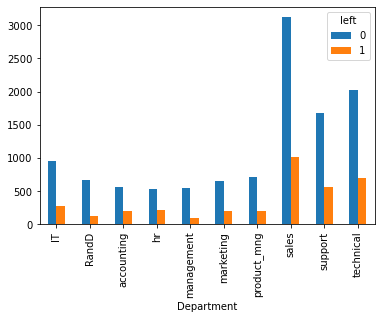

In [7]:
pd.crosstab(hr.Department,hr.left).plot(kind='bar')

<AxesSubplot:xlabel='salary'>

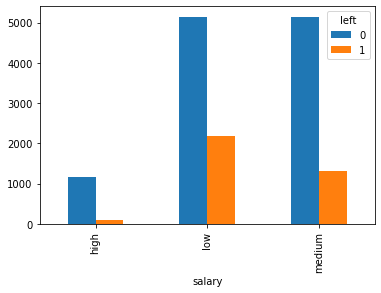

In [9]:
pd.crosstab(hr.salary,hr.left).plot(kind='bar')

Calculate imbalance, we see there is left is 31.24% of the data. While staying is 68.75%

In [ ]:
leaving = (hr[hr['left']==1].count()/hr[hr['left']==0].count())*100
staying = 100-leaving

print(leaving, staying)

Creating a dataframe 'feature_cols' in order to apply this data to the X variablel in the decision tree and the logistic regression. Besides, with the function get_dummies from pandas, we separate the salary into high, low and medium and apply a zero or one wether the condition is true yes or no. We merge both dataframes into 'dum' and drop the salary column. 

In [10]:
feature_cols = hr[['satisfaction_level','average_montly_hours','promotion_last_5years','salary']]
salary = pd.get_dummies(feature_cols['salary'])
dum = pd.concat([feature_cols,salary],axis='columns')
dum.drop('salary',axis='columns',inplace=True)

dum.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,high,low,medium
0,0.38,157,0,0,1,0
1,0.80,262,0,0,0,1
2,0.11,272,0,0,0,1
3,0.72,223,0,0,1,0
4,0.37,159,0,0,1,0


We select hr.left as response variable for our model. X contains the variables in the dum dataframe, described above. We perform a train_test_split on X and y where we set 75% of the data to the training model and we keep 25% of the data apart for testing. 

In [43]:
np.random.seed(1234)
y_log = hr.left 
X_log = dum
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.25)

We create a model for logistic regression and fit it on the training data. 

In [44]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

LogisticRegression()

We apply the trained model on the test set.

In [45]:
model_log.predict(X_test)
y_pred_log = model_log.predict(X_test)

In [46]:
model_log.score(X_test,y_test)

0.7762666666666667

In [47]:
y_pred_log = model_log.predict(X_test)

Creating a confusion matrix in order to calculate the classification metrics.

In [48]:

matrix_log = metrics.confusion_matrix(y_test, y_pred_log)
matrix_log

array([[2667,  156],
       [ 683,  244]])

The diagonal observations in the confusion matrix are the actual correct predicted values. While for example, actual is one but is predicted as zero. 

There is imbalance in the dataset for left and stay, which means that accuracy is not a good parameter to use since 68.75% of the time the worker stays at the company. 

Precision is more reliable and is for modelD the highest. This means that there is a high precision that the model predicted that i.e there are 100 workers and 80 were true positive, this will lead to a precision of 80%. Recall says if we predict 100 workers are staying 94 of these workers are actually staying. This is a recall of 94%. So the higher the precision and recall the better the model in this case. 


In [50]:
target_names = ['Stay', 'Leaving']
print(classification_report(y_test, y_pred_log, target_names=target_names))

              precision    recall  f1-score   support

        Stay       0.80      0.94      0.86      2823
     Leaving       0.61      0.26      0.37       927

    accuracy                           0.78      3750
   macro avg       0.70      0.60      0.62      3750
weighted avg       0.75      0.78      0.74      3750



There are two classes 0 and 1. The confusion matrix shows in the output, 2667 and 244 are actual predictions, and 683 and 156 are incorrect predictions.

Text(0.5, 15.0, 'Predicted')

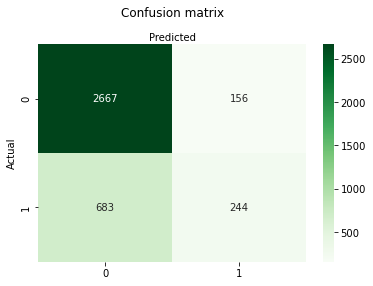

In [51]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix_log), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')


Printing the AUC of 78.2%

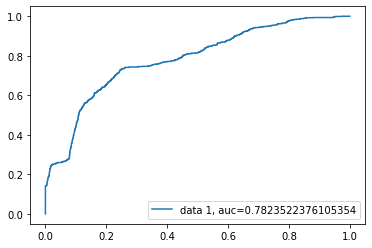

In [52]:
y_pred_proba = model_log.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Decision Tree

Building the tree and fit it on training data 

In [53]:
np.random.seed(1234)

y_tree = hr.left 
X_tree = dum
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.25)
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

In [54]:
target_names = ['Stay', 'Leaving']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Stay       0.96      0.94      0.95      2823
     Leaving       0.84      0.87      0.85       927

    accuracy                           0.92      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.93      0.92      0.93      3750



In [ ]:

feature_cols = ['satisfaction_level',	'average_montly_hours',	'promotion_last_5years',	'high',	'low',	'medium']
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('/Users/rickvanmil/Downloads/tree.png')
Image(graph.create_png())



Text(0.5, 15.0, 'Predicted')

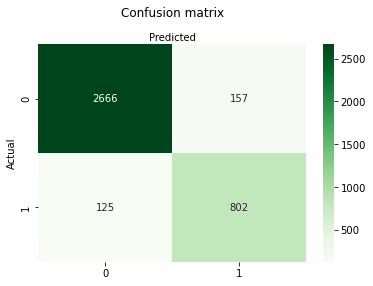

In [56]:

matrix = metrics.confusion_matrix(y_test, y_pred)
matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

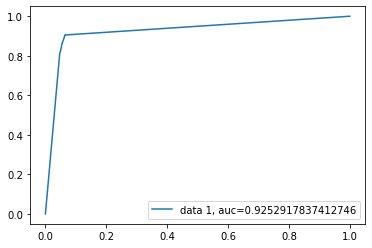

In [57]:
y_pred_tree_prob = tree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_tree_prob)
auc = metrics.roc_auc_score(y_test, y_pred_tree_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Conclusion: the decision tree model predicts better if a worker leaves the company or not. The decision tree renders an AUC of 95.53% while the AUC of logistic regression is only 78.24%. Also, in the confusion matrix we see better predictions originated from the decision tree. It performs better on precision and recall. 